This notebook shows how NormalPowerAnalysis and PowerAnalysis calculators give similar powers for a switchback experiment, and the normal one is way faster.

In [1]:
from datetime import date

import numpy as np
from cluster_experiments import PowerAnalysis, ConstantPerturbator, BalancedClusteredSplitter, ExperimentAnalysis, ClusteredOLSAnalysis, NormalPowerAnalysis
import pandas as pd
from time import time



# Create fake data
N = 10_000
clusters = [f"Cluster {i}" for i in range(10)]
dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(1, 15)]
df = pd.DataFrame(
    {
        "cluster": np.random.choice(clusters, size=N),
        "date": np.random.choice(dates, size=N),
    }
).assign(
    # Target is a linear combination of cluster and day of week, plus some noise
    cluster_id=lambda df: df["cluster"].astype("category").cat.codes,
    day_of_week=lambda df: pd.to_datetime(df["date"]).dt.dayofweek,
    target=lambda df: df["cluster_id"] + df["day_of_week"] + np.random.normal(size=N),
)


In [2]:
df.head()

,cluster,date,cluster_id,day_of_week,target
0,Cluster 3,2022-01-12,3,2,5.206403
1,Cluster 3,2022-01-14,3,4,7.004311
2,Cluster 9,2022-01-06,9,3,11.554722
3,Cluster 1,2022-01-10,1,0,2.697168
4,Cluster 8,2022-01-14,8,4,10.311295


Some clusters have a higher average outcome than others

In [3]:
cluster_cols = ["cluster", "date"]

splitter = BalancedClusteredSplitter(
    cluster_cols=cluster_cols,
)

perturbator = ConstantPerturbator()

analysis = ClusteredOLSAnalysis(
    cluster_cols=cluster_cols,
)

alpha = 0.05
n_simulations = 100
n_simulations_normal = 10

# Simulated power analysis, we use clustered splitter and ols clustered analysis
pw_simulated = PowerAnalysis(
    splitter=splitter,
    perturbator=perturbator,
    alpha=alpha,
    n_simulations=n_simulations,
    analysis=analysis,
)

# Normal power analysis, uses Central limit theorem to estimate power, and needs less simulations
pw_normal = NormalPowerAnalysis(
    splitter=splitter,
    alpha=alpha,
    n_simulations=n_simulations_normal,
    analysis=analysis,
)


In [4]:
# power line for simulated
effects = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
time_pw = time()
pw_simulated_line = pw_simulated.power_line(df, average_effects=effects)
print(f"Simulated power line took {time() - time_pw} seconds")

In [ ]:
# power line for normal
time_pw = time()
pw_normal_line = pw_normal.power_line(df, average_effects=effects)
print(f"Time for normal power line: {time() - time_pw} seconds")

Time for normal power line: 0.40550780296325684 seconds


In [ ]:
# power line for normal, single simulation
time_pw = time()
pw_normal.n_simulations = 1
pw_normal_line_single = pw_normal.power_line(df, average_effects=effects)
print(f"Time for normal power line single simulation: {time() - time_pw} seconds")

Time for normal power line single simulation: 0.06014275550842285 seconds


<AxesSubplot:title={'center':'Power analysis'}, xlabel='Average effect', ylabel='Power'>

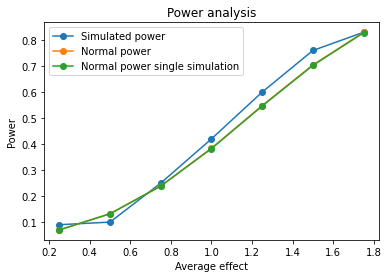

In [ ]:
pd.DataFrame(
    {
        "Average effect": effects,
        "Simulated power": pw_simulated_line.values(),
        "Normal power": pw_normal_line.values(),
        "Normal power single simulation": pw_normal_line_single.values(),
    }
).plot(
    x="Average effect",
    y=["Simulated power", "Normal power", "Normal power single simulation"],
    title="Power analysis",
    xlabel="Average effect",
    ylabel="Power",
    marker="o",
)

In [ ]:
# pw_normal can also be used to find MDE
mde = pw_normal.mde(df, power=0.7)
print(f"Minimum detectable effect: {mde:.2f}")

# and we can retrieve the power for a given effect size
power = pw_normal.power_analysis(df, average_effect=mde)
print(f"Power for MDE: {power:.2f}, should be 0.7")